In [9]:
using Pkg
using Plots, LaTeXStrings, Measures
Pkg.activate("/home/julisn/Codes/MFDecoupling.jl")
using MFDecoupling
using JLD2, DataFrames
using Statistics

  Activating project at `~/Codes/MFDecoupling.jl`


In [41]:
fn_pt = "/home/julisn/Hamburg/Projects/MFDecoupling/data/out_pt1.jld2"
fn_coarse = "/home/julisn/Hamburg/Projects/MFDecoupling/data/out_coarse.jld2"
fn_smallU = "/home/julisn/Hamburg/Projects/MFDecoupling/data/out_smallU.jld2"

Uin = 0.1
Vin = 0.5

0.5

In [102]:
function build_df(fn::String)
    df = DataFrame(U = Float64[], V = Float64[], t = Vector{Float64}[],        rho11 = Vector{ComplexF64}[], rho12 = Vector{ComplexF64}[],
                   rho13 = Vector{ComplexF64}[], rho14 = Vector{ComplexF64}[], rho22 = Vector{ComplexF64}[], rho23 = Vector{ComplexF64}[],
                   rho24 = Vector{ComplexF64}[], rho33= Vector{ComplexF64}[],  rho34 = Vector{ComplexF64}[], rho44 = Vector{ComplexF64}[], C01 = Vector{ComplexF64}[])
    if isfile(fn)
        rU, rV, rT, rS = jldopen(fn,"r") do ft
            ft["U"], ft["V"], ft["t"], ft["solution"]
        end
        for i in 1:length(rU)
            row = [rU[i], rV[i], rT, eachslice(rS[:,:,i],dims=1)...]
            push!(df,row)
        end
    elseif isdir(fn)
        fl = readdir(fn, join=true)
        filter!(x-> endswith(x,"jld2"), fl)
        for fi in fl
            rU, rV, rT, rS = jldopen(fi,"r") do fii
                tmp = keys(fii)[1]
                #V = haskey(fii["$tmp"], "V") ? fii["$tmp/V"] : NaN
                if haskey(fii, "U")
                    fii["U"], fii["V"], fii["t"], fii["sol"]
                else
                    fii["$tmp/U"], NaN, fii["$tmp/t"], fii["$tmp/sol"]
                end
            end
            row = [rU, rV, rT, eachslice(rS,dims=1)...]
            push!(df,row)
        end
    else
        error("$fn is not a result file or directory!")
    end
    return df
end
df_pt= build_df(fn_pt);
df_coarse = build_df(fn_coarse);
df_smallU = build_df(fn_smallU);

# combine and remove duplicates
df = combine(groupby(vcat(df_pt,df_coarse, df_smallU), [:U, :V]), last); 


df[!,:f_up] = df[:,:rho13] .+ df[:,:rho24]
df[!,:f_do] = df[:,:rho12] .+ df[:,:rho34]

# supplement mean value
lim_ind = 1000
var_window = trunc(Int, length(df[1,:t]) / 10)
for cn in names(df)[4:end]
    df[!,Symbol(cn * "_lim")] = map(x-> mean(x[end-lim_ind:end]), df[:,Symbol(cn)])
    df[!,Symbol(cn * "_std")] = map(x-> [std(x[i-var_window:i]) for i in var_window+1:length(x)], df[:,Symbol(cn)])
end

# calculate ffts of time series
fft_cols = ["rho11", "f_up", "C01"]
for cl in fft_cols
    df[!,Symbol(cl * "_fft")] = map(x-> FourierAnalysis.fft(real(x[1] .- x[2])) ./ length(x[1]) |> FourierAnalysis.fftshift, eachrow(df[:,[Symbol(cl),Symbol(cl * "_lim")]]))
end

sort!(df_Vin, [:U])

VList = sort(unique(df.V))

40-element Vector{Float64}:
  0.0
  0.2222222222222222
  0.3448275862068966
  0.4444444444444444
  0.5
  0.6666666666666666
  0.6896551724137931
  0.8888888888888888
  1.0344827586206897
  1.1111111111111112
  1.3333333333333333
  1.3793103448275863
  1.5555555555555556
  ⋮
  6.206896551724138
  6.551724137931034
  6.8965517241379315
  7.241379310344827
  7.586206896551724
  7.931034482758621
  8.275862068965518
  8.620689655172413
  8.96551724137931
  9.310344827586206
  9.655172413793103
 10.0

# Investigation at V = V_in

- physical meaning of rho diagonal and off-diagonal

- No decay for U < U_in (THIS CONTRADICTS PAPER!!!)
- Constant at U = U_in (equilibrium solution)
- decay for U_in < U < U_c
- ??? U > U_c

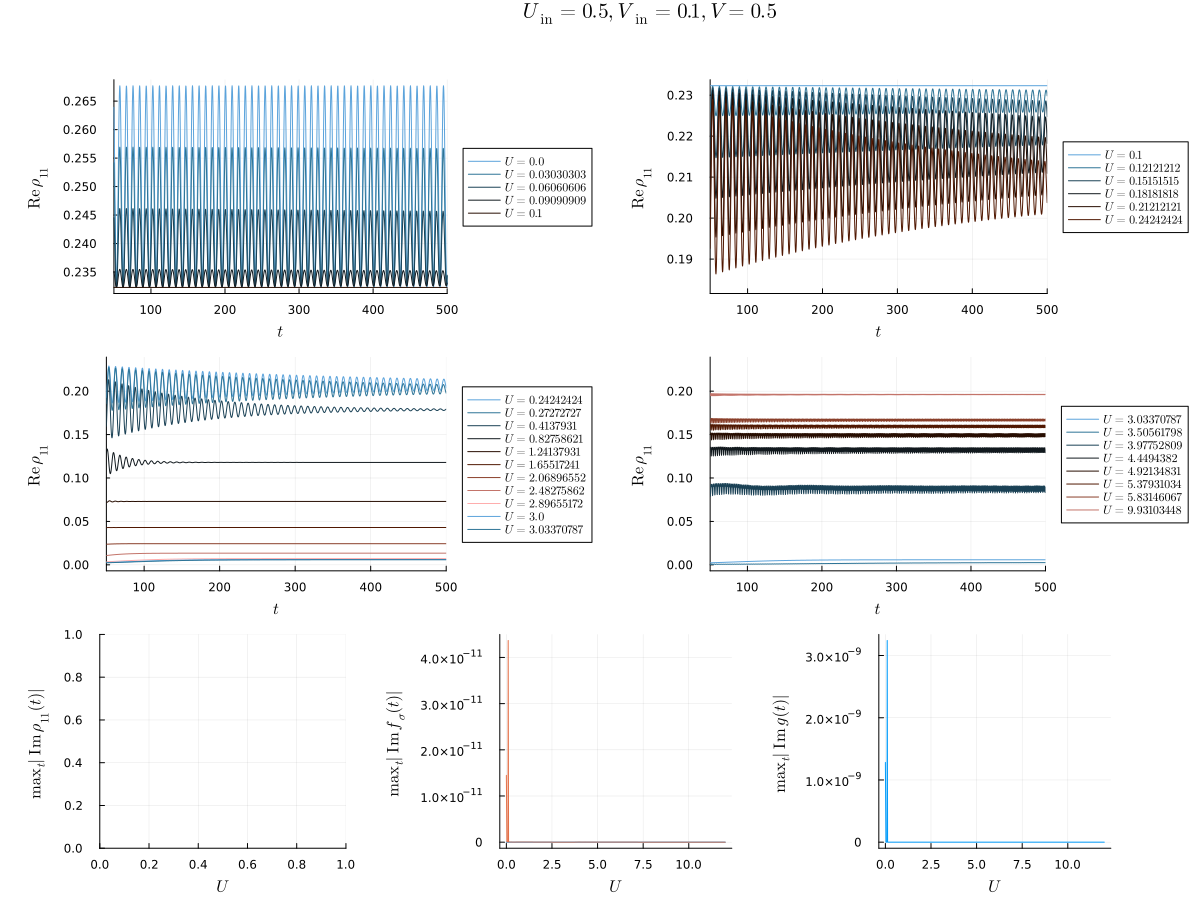

In [109]:
UList_Vin = sort(unique(df_Vin.U))
pa = plot(title=L"U_\mathrm{in}=%$Vin,V_\mathrm{in}=%$Uin,V=0.5", grid=false,showaxis=false,bottom_margn=-0mm)
p0 = plot(legend=:outerright,palette=:berlin10, xlabel=L"t", ylabel=L"\mathrm{Re}\, \rho_{11}",xlims=(50,500))
p1 = plot(legend=:outerright,palette=:berlin10, xlabel=L"t", ylabel=L"\mathrm{Re}\, \rho_{11}",xlims=(50,500))
p2 = plot(legend=:outerright,palette=:berlin10, xlabel=L"t", ylabel=L"\mathrm{Re}\, \rho_{11}",xlims=(50,500))
p3 = plot(legend=:outerright,palette=:berlin10, xlabel=L"t", ylabel=L"\mathrm{Re}\, \rho_{11}",xlims=(50,500))
p4 = plot(legend=nothing, xlabel=L"U", ylabel=L"\max_t | \mathrm{Im}\,\rho_{11} (t)|")
p5 = plot(legend=nothing, xlabel=L"U", ylabel=L"\max_t | \mathrm{Im}\,f_\sigma (t)|") 
p6 = plot(legend=nothing, xlabel=L"U", ylabel=L"\max_t | \mathrm{Im}\,g(t)|")
for Ui in UList_Vin[1:1:5]
    plot!(p0, df_Vin[df_Vin.U .≈ Ui,:t], real.(df_Vin[df_Vin.U .≈ Ui,:rho11]), label=L"U=%$(round(Ui,digits=8))")
end

for Ui in UList_Vin[5:10]
    plot!(p1, df_Vin[df_Vin.U .≈ Ui,:t], real.(df_Vin[df_Vin.U .≈ Ui,:rho11]), label=L"U=%$(round(Ui,digits=8))")
end
for Ui in UList_Vin[10:20]
    plot!(p2, df_Vin[df_Vin.U .≈ Ui,:t], real.(df_Vin[df_Vin.U .≈ Ui,:rho11]), label=L"U=%$(round(Ui,digits=8))")
end
for Ui in UList_Vin[20:15:end]
    plot!(p3, df_Vin[df_Vin.U .≈ Ui,:t], real.(df_Vin[df_Vin.U .≈ Ui,:rho11]), label=L"U=%$(round(Ui,digits=8))")
end

plot!(p5, df_Vin.U, map(x -> maximum(abs.(imag(x))), df_Vin[:,:rho11]))
plot!(p5, df_Vin.U, map(x -> maximum(abs.(imag(x))), df_Vin[:,:f_up]))
plot!(p6, df_Vin.U, map(x -> maximum(abs.(imag(x))), df_Vin[:,:C01]))

l = @layout [
    tt{1.0w, 0.001h}
    a{0.5w} b{0.5w} 
    c{0.5w} d{0.5w} 
    e{0.3w} f{0.3w}  g{0.3w}
    ]
plot(pa, p0, p1, p2, p3, p4, p5, p6, layout=l, size=(1200,900), left_margin=10mm)

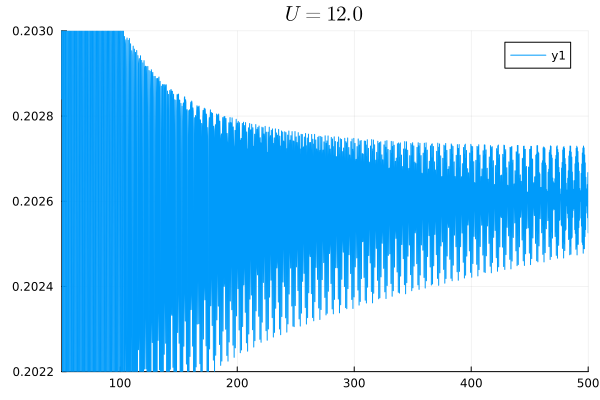

In [110]:
plot(df_Vin[df_Vin.U .≈ UList_Vin[end],:t], real.(df_Vin[df_Vin.U .≈ UList_Vin[end],:rho11]), title=L"U=%$(round(UList_Vin[end],digits=8))", xlims=(50,500), ylims=(0.2022,0.203))

5

L"$U_\mathrm{C} = 3.6741573033707864$"

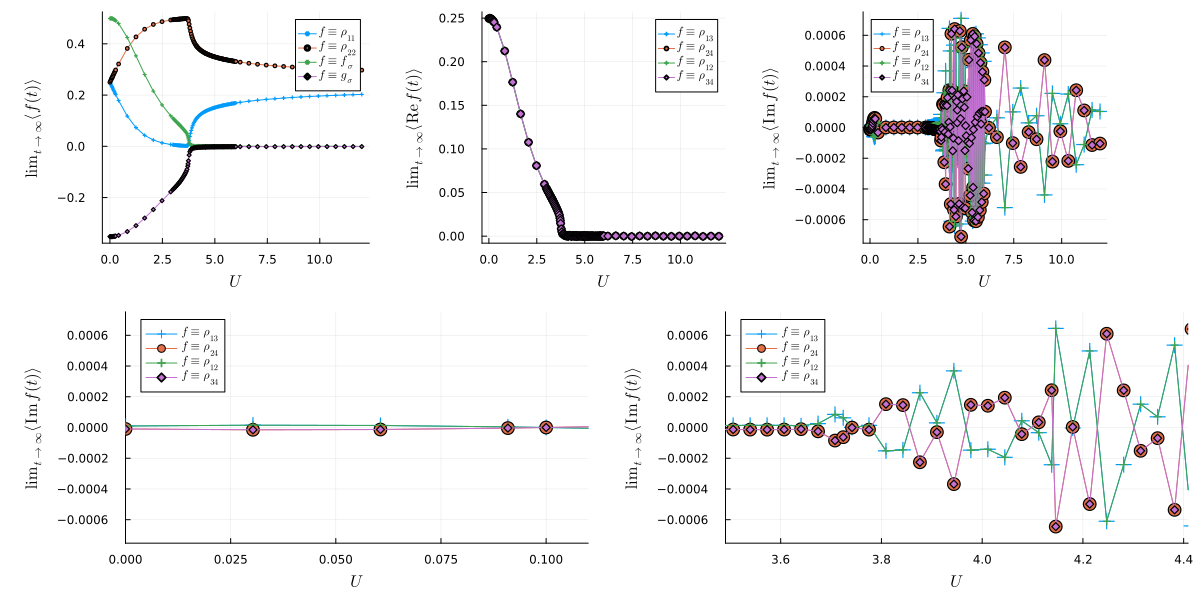

In [116]:
Ux = df_Vin.U
sort!(df_Vin, [:U])
U_c_i = argmin(real(df_Vin.rho11_lim))
U_c = Ux[U_c_i]
U_in_i = findfirst(x->x≈Uin,Ux)
display(L"U_\mathrm{C} = %$(U_c)")

#p0 = plot(legend=:outerright,palette=:berlin10, title=L"U_\mathrm{in}=0.1,V_\mathrm{in}=0.5,V=0.5", xlabel=L"t", ylabel=L"\Re \rho_{11}",xlims=(50,500))
#p1 = plot(legend=:outerright,palette=:berlin10, title=L"U_\mathrm{in}=0.1,V_\mathrm{in}=0.5,V=0.5", xlabel=L"t", ylabel=L"\Re \rho_{11}",xlims=(50,500))

                    
p2 = plot(Ux, real(df_Vin.rho11_lim), xlabel=L"U", ylabel=L"\lim_{t \to \infty} \langle f(t) \rangle",legend=:topright, markershape=:auto, label=L"f \equiv \rho_{11}", markersize=2)
plot!(Ux, real(df_Vin.rho22_lim), label=L"f \equiv \rho_{22}",  markershape=:auto, markersize=2)
plot!(Ux, real(df_Vin.f_up_lim), label=L"f \equiv f_{\sigma}",  markershape=:auto, markersize=2)
plot!(Ux, real(df_Vin.C01_lim), label=L"f \equiv g_{\sigma}",  markershape=:auto, markersize=2)
p3 = plot(Ux, real(df_Vin.rho13_lim), xlabel=L"U", ylabel=L"\lim_{t \to \infty}  \langle \mathrm{Re}\,f(t)\rangle",legend=:topright, markershape=:auto, label=L"f \equiv \rho_{13}")
plot!(Ux, real(df_Vin.rho24_lim), label=L"f \equiv \rho_{24}",  markershape=:auto)
plot!(Ux, real(df_Vin.rho12_lim), label=L"f \equiv \rho_{12}",  markershape=:auto)
plot!(Ux, real(df_Vin.rho34_lim), label=L"f \equiv \rho_{34}",  markershape=:auto)
p4 = plot(Ux, imag(df_Vin.rho13_lim), xlabel=L"U", ylabel=L"\lim_{t \to \infty} \langle \mathrm{Im}\, f(t)\rangle",legend=:topleft, markershape=:auto, label=L"f \equiv \rho_{13}", markersize=8)
plot!(Ux, imag(df_Vin.rho24_lim), label=L"f \equiv \rho_{24}",  markershape=:auto, markersize=7)
plot!(Ux, imag(df_Vin.rho12_lim), label=L"f \equiv \rho_{12}",  markershape=:auto)
plot!(Ux, imag(df_Vin.rho34_lim), label=L"f \equiv \rho_{34}",  markershape=:auto)

p5 = plot(Ux, imag(df_Vin.rho13_lim), xlabel=L"U", ylabel=L"\lim_{t \to \infty} \langle \mathrm{Im}\, f(t)\rangle",legend=:topleft, markershape=:auto, label=L"f \equiv \rho_{13}", markersize=8, xlims=(0.0,0.11))
plot!(Ux, imag(df_Vin.rho24_lim), label=L"f \equiv \rho_{24}",  markershape=:auto, markersize=7)
plot!(Ux, imag(df_Vin.rho12_lim), label=L"f \equiv \rho_{12}",  markershape=:auto)
plot!(Ux, imag(df_Vin.rho34_lim), label=L"f \equiv \rho_{34}",  markershape=:auto)

p6 = plot(Ux, imag(df_Vin.rho13_lim), xlabel=L"U", ylabel=L"\lim_{t \to \infty} \langle \mathrm{Im}\, f(t)\rangle",legend=:topleft, markershape=:auto, label=L"f \equiv \rho_{13}", markersize=8, xlims=(U_c - U_c/20, U_c + U_c/5))
plot!(Ux, imag(df_Vin.rho24_lim), label=L"f \equiv \rho_{24}",  markershape=:auto, markersize=7)
plot!(Ux, imag(df_Vin.rho12_lim), label=L"f \equiv \rho_{12}",  markershape=:auto)
plot!(Ux, imag(df_Vin.rho34_lim), label=L"f \equiv \rho_{34}",  markershape=:auto)

p7 = plot(legend=:outerright,palette=:berlin10, xlabel=L"t", ylabel=L"\mathrm{Re}\, \rho_{11}",xlims=(50,500))
for Ui in UList_Vin[1:U_in_i]
    plot!(p7, df_Vin[df_Vin.U .≈ Ui,:t], real.(df_Vin[df_Vin.U .≈ Ui,:rho11]), label=L"U=%$(round(Ui,digits=8))")
end

p8 = plot(legend=:outerright,palette=:berlin10, title=L"U_\mathrm{in}=0.1,V_\mathrm{in}=0.5,V=0.5", xlabel=L"t", ylabel=L"\mathrm{Re}\, \rho_{11}",xlims=(50,500))
for Ui in UList_Vin[U_c_i-10:U_c_i+50]
    plot!(p8, df_Vin[df_Vin.U .≈ Ui,:t], real.(df_Vin[df_Vin.U .≈ Ui,:rho11]), label=L"U=%$(round(Ui,digits=8))")
end

l = @layout [
        a{0.3w} b{0.3w}  c{0.3w}
        c{0.5w} d{0.5w} 
        #e{0.5w} f{0.5w} 
    ]
p = plot(p2,p3,p4,p5,p6,size=(1200,600), layout=l, left_margin=10mm, bottom_margin=5mm)
savefig("U_scale.pdf")
display(p)

In [130]:
cl = "rho11"
map(x-> FourierAnalysis.fft(real(x[1] .- x[2])) ./ length(x[1]) |> FourierAnalysis.fftshift, eachrow(df_Vin[:,[Symbol(cl),Symbol(cl * "_lim")]]))

130-element Vector{Vector{ComplexF64}}:
 [-4.090836614211755e-7 - 6.417121608398579e-21im, -4.092349722787003e-7 - 1.018674417693481e-9im, -4.091645206577103e-7 - 1.83872860154885e-9im, -4.0911579033506805e-7 - 2.9576314520677843e-9im, -4.092631245586073e-7 - 3.830494501090543e-9im, -4.090944614175431e-7 - 4.741026895876911e-9im, -4.091644686417186e-7 - 5.848083990131353e-9im, -4.091957171023493e-7 - 6.652066121037292e-9im, -4.0905716422505345e-7 - 7.701355982537284e-9im, -4.0920237428937e-7 - 8.690736566175984e-9im  …  -4.090938647378199e-7 + 9.527305899083762e-9im, -4.092023742893717e-7 + 8.690736566173572e-9im, -4.090571642250501e-7 + 7.701355982537962e-9im, -4.091957171023518e-7 + 6.6520661210418595e-9im, -4.0916446864172206e-7 + 5.848083990130913e-9im, -4.0909446141754765e-7 + 4.741026895874519e-9im, -4.092631245586071e-7 + 3.830494501089662e-9im, -4.091157903350695e-7 + 2.9576314520658057e-9im, -4.091645206577076e-7 + 1.8387286015514793e-9im, -4.092349722787003e-7 + 1.01867441768

In [122]:
tt = df_Vin[:,[:rho11,:rho11_lim]]

130×2 DataFrame
 Row │ rho11                              rho11_lim       
     │ Array…                             Complex…        
─────┼────────────────────────────────────────────────────
   1 │ ComplexF64[0.2323+0.0im, 0.23257…   0.249957+0.0im
   2 │ ComplexF64[0.2323+0.0im, 0.23249…   0.244596+0.0im
   3 │ ComplexF64[0.2323+0.0im, 0.23240…   0.239243+0.0im
   4 │ ComplexF64[0.2323+0.0im, 0.23232…     0.2339+0.0im
   5 │ ComplexF64[0.2323+0.0im, 0.2323+…     0.2323+0.0im
   6 │ ComplexF64[0.2323+0.0im, 0.23224…    0.22857+0.0im
   7 │ ComplexF64[0.2323+0.0im, 0.23215…   0.223254+0.0im
   8 │ ComplexF64[0.2323+0.0im, 0.23207…   0.217954+0.0im
   9 │ ComplexF64[0.2323+0.0im, 0.23199…   0.212674+0.0im
  10 │ ComplexF64[0.2323+0.0im, 0.23190…   0.207418+0.0im
  11 │ ComplexF64[0.2323+0.0im, 0.23182…   0.202197+0.0im
  ⋮  │                 ⋮                         ⋮
 121 │ ComplexF64[0.2323+0.0im, 0.21183…   0.188375+0.0im
 122 │ ComplexF64[0.2323+0.0im, 0.21099…   0.190622+0.0im
 123 │ ComplexF64[0.2323+0.0im, 0.21019…   0.192643+0.0im
 124 │ ComplexF64[0.2323+0.0im, 0.20941…   0.194469+0.0im
 125 │ ComplexF64[0.2323+0.0im, 0.20866…   0.196131+0.0im
 126 │ ComplexF64[0.2323+0.0im, 0.20794…   0.197649+0.0im
 127 │ ComplexF64[0.2323+0.0im, 0.20725…    0.19904+0.0im
 128 │ ComplexF64[0.2323+0.0im, 0.20660…   0.200323+0.0im
 129 │ ComplexF64[0.2323+0.0im, 0.20598…   0.201507+0.0im
 130 │ ComplexF64[0.2323+0.0im, 0.20539…   0.202606+0.0im
                                          109 rows omitted

In [125]:
eachrow(tt)

130×2 DataFrameRows
 Row │ rho11                              rho11_lim       
     │ Array…                             Complex…        
─────┼────────────────────────────────────────────────────
   1 │ ComplexF64[0.2323+0.0im, 0.23257…   0.249957+0.0im
   2 │ ComplexF64[0.2323+0.0im, 0.23249…   0.244596+0.0im
   3 │ ComplexF64[0.2323+0.0im, 0.23240…   0.239243+0.0im
   4 │ ComplexF64[0.2323+0.0im, 0.23232…     0.2339+0.0im
   5 │ ComplexF64[0.2323+0.0im, 0.2323+…     0.2323+0.0im
   6 │ ComplexF64[0.2323+0.0im, 0.23224…    0.22857+0.0im
   7 │ ComplexF64[0.2323+0.0im, 0.23215…   0.223254+0.0im
   8 │ ComplexF64[0.2323+0.0im, 0.23207…   0.217954+0.0im
   9 │ ComplexF64[0.2323+0.0im, 0.23199…   0.212674+0.0im
  10 │ ComplexF64[0.2323+0.0im, 0.23190…   0.207418+0.0im
  11 │ ComplexF64[0.2323+0.0im, 0.23182…   0.202197+0.0im
  ⋮  │                 ⋮                         ⋮
 121 │ ComplexF64[0.2323+0.0im, 0.21183…   0.188375+0.0im
 122 │ ComplexF64[0.2323+0.0im, 0.21099…   0.190622+0.0im
 123 │ ComplexF64[0.2323+0.0im, 0.21019…   0.192643+0.0im
 124 │ ComplexF64[0.2323+0.0im, 0.20941…   0.194469+0.0im
 125 │ ComplexF64[0.2323+0.0im, 0.20866…   0.196131+0.0im
 126 │ ComplexF64[0.2323+0.0im, 0.20794…   0.197649+0.0im
 127 │ ComplexF64[0.2323+0.0im, 0.20725…    0.19904+0.0im
 128 │ ComplexF64[0.2323+0.0im, 0.20660…   0.200323+0.0im
 129 │ ComplexF64[0.2323+0.0im, 0.20598…   0.201507+0.0im
 130 │ ComplexF64[0.2323+0.0im, 0.20539…   0.202606+0.0im
                                          109 rows omitted

In [112]:
using FourierAnalysis
ii = U_in_i+2
freq_cut = 1.5

r11_i = real(df_Vin[ii,:rho11])
rho11_lim = real(df_Vin[ii,:rho11_lim])
fs_i = real(df_Vin[ii,:f_up])
f_lim = real(df_Vin[ii,:f_up_lim])
gs_i = real(df_Vin[ii,:C01])
g_lim = real(df_Vin[ii,:C01_lim])
tx = df_Vin[ii,:t]
U_i = df_Vin[ii, :U]

slice = 1:length(r11_i)
tx_fft = tx[slice]
r11_fft = FourierAnalysis.fft(r11_i[slice] .- rho11_lim)[1:end] ./ length(slice)  |> FourierAnalysis.fftshift
r11_fft_full = FourierAnalysis.fft(r11_i[slice])[1:end] ./ length(slice)  |> FourierAnalysis.fftshift
freqs = FourierAnalysis.fftfreq(length(tx_fft), 1.0/diff(tx_fft)[1]) |> FourierAnalysis.fftshift

fs_fft = FourierAnalysis.fft(fs_i[slice] .- f_lim)[1:end] ./ length(slice)  |> FourierAnalysis.fftshift
gs_fft = FourierAnalysis.fft(gs_i[slice] .- g_lim)[1:end] ./ length(slice)  |> FourierAnalysis.fftshift



p1 = plot(tx, r11_i .- rho11_lim, ylims=(-0.0001,0.0001),
        title=L"U=%$(round(U_i,digits=2))", xlabel=L"\mathrm{t}", ylabel=L"f - \lim_{t \to \infty} \langle f(t) \rangle", label=L"f \equiv \rho_{11};\, \lim_{t\to\infty} \rho_{11}  \approx %$(round(rho11_lim,digits=2))")
#vline!([tx[first(slice)]], color=:orange, label="FT start")
plot!(tx, fs_i .- f_lim, label=L"f \equiv f_\sigma;\; \lim_{t\to\infty} f_\sigma \approx %$(round(f_lim,digits=2))")
plot!(tx, gs_i .- g_lim, label=L"f \equiv g_\sigma;\; \lim_{t\to\infty} g_\sigma \approx %$(round(g_lim,digits=2))")
vline!([avg_start], label=L"\mathrm{avg.\,start}", ls=:dash,lw=3,alpha=0.5)

p2 = plot(freqs, abs.(r11_fft), xlabel=L"\omega [\mathrm{Hz}]", label=L" | \mathcal{F}[\mathrm{\rho_{11}} - \langle \rho_{11} \rangle] |", xlims=(-freq_cut,freq_cut))

plot!(freqs, abs.(fs_fft), xlabel=L"\omega [\mathrm{Hz}]", label=L"| \mathcal{F}[\mathrm{f_\sigma} - \langle f_\sigma \rangle] |", xlims=(-freq_cut,freq_cut))
plot!(freqs, abs.(gs_fft),  xlabel=L"\omega [\mathrm{Hz}]", label=L"| \mathcal{F}[\mathrm{g_\sigma}  - \langle g_\sigma \rangle] |", xlims=(-freq_cut,freq_cut))

spectrums_rho = Array{Float64, 2}(undef, length(slice), nm)
spectrums_f = Array{Float64, 2}(undef, length(slice), nm)
spectrums_g = Array{Float64, 2}(undef, length(slice), nm)
for i in 1:nm
    r11_i = r11_all[:,i]
    rho11_lim = mean(r11_i[end-100:end])
    r11_fft = FourierAnalysis.fft(r11_i[slice] .- mean(r11_i[end-avg_start:end]))[1:end] ./ length(slice)  |> FourierAnalysis.fftshift
    freqs = FourierAnalysis.fftfreq(length(tx_fft), 1.0/diff(tx_fft)[1]) |> FourierAnalysis.fftshift
    spectrums_rho[:,i] .= log.(abs.(r11_fft))


    fs_i = f_all[:,i]
    fs_fft = FourierAnalysis.fft(fs_i[slice] .- mean(fs_i[end-avg_start:end]))[1:end] ./ length(slice)  |> FourierAnalysis.fftshift
    spectrums_f[:,i] .= log.(abs.(fs_fft))

    gs_i = g_all[:,i]
    gs_fft = FourierAnalysis.fft(gs_i[slice] .- mean(gs_i[end-avg_start:end]))[1:end] ./ length(slice)  |> FourierAnalysis.fftshift
    spectrums_g[:,i] .= log.(abs.(gs_fft))
end

p3 = heatmap(Ux,freqs,spectrums_rho,clims=(-10,-4), ylims=(0,freq_cut), xlabel=L"U", ylabel=L"\omega [\mathrm{Hz}]", title=L"\log \,|\mathcal{F}[\rho_{11}(t)]|",legend=nothing)
p4 = heatmap(Ux,freqs,spectrums_f,clims=(-10,-4), ylims=(0,freq_cut), xlabel=L"U",  title=L"\log \,|\mathcal{F}[f_\sigma(t)]|",legend=nothing)
p5 = heatmap(Ux,freqs,spectrums_g,clims=(-10,-4), ylims=(0,freq_cut), xlabel=L"U",  title=L"\log \,|\mathcal{F}[g_\sigma(t)]|", framestyle=:box)
l = @layout [
    [a{0.5w} b{0.5w}]
    [c{0.25w} d{0.25w} e{0.5w}]
    ]
p = plot(p1, p2, p3, p4, p5, layout=l,size=(1200,600), left_margin=20mm, bottom_margin=10mm)
savefig("fourier.pdf")
display(p)

LoadError: UndefVarError: `nm` not defined

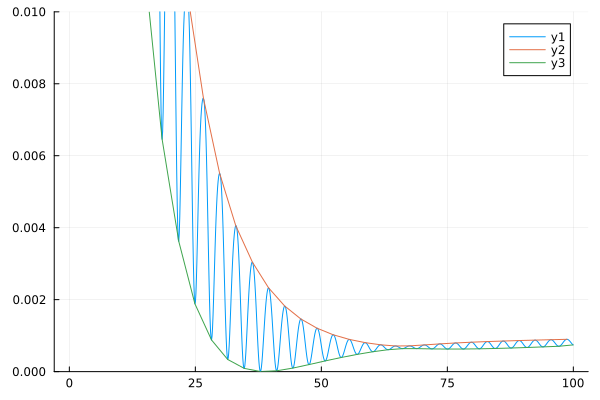

In [140]:
#y=analyticsignal(r11_0)
using Images
maxy_ix = findlocalmaxima(r11_0)
miny_ix = findlocalminima(r11_0)
plot(tx, r11_0, ylims=(0.0,0.01))
plot!(tx[maxy_ix],r11_0[maxy_ix])
plot!(tx[miny_ix],r11_0[miny_ix])

# Fourier Spectrum of f and g

# Amplitude (contratidction with paper)
# std? of time plot
# lim of amplitude plot (extrapolate!!!!)

# Effects of V

- V -> oo : higher frequency
- V > V_C : more than one frequency

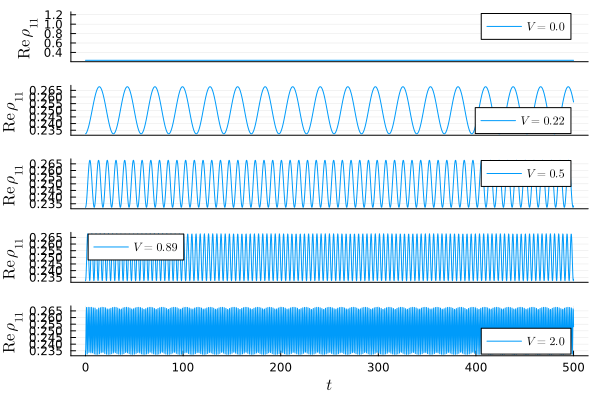

In [56]:
tt = df[df.U .≈ 0.0 .&& df.V .≈ 0.0,:]
p1 = plot(tt.t, real(tt.rho11), xaxis=nothing, ylabel=L"\mathrm{Re}\,\rho_{11}", label=L"V=%$0.0")
tt = df[df.U .≈ 0.0 .&& df.V .≈ VList[2],:]
p2 = plot(tt.t, real(tt.rho11), xaxis=nothing, ylabel=L"\mathrm{Re}\,\rho_{11}", label=L"V=%$(round(VList[2],digits=2))")
tt = df[df.U .≈ 0.0 .&& df.V .≈ 0.5,:]
p3 = plot(tt.t, real(tt.rho11), xaxis=nothing, ylabel=L"\mathrm{Re}\,\rho_{11}", label=L"V=%$(round(0.5,digits=2))")
tt = df[df.U .≈ 0.0 .&& df.V .≈ VList[6],:]
p4 = plot(tt.t, real(tt.rho11), xaxis=nothing, ylabel=L"\mathrm{Re}\,\rho_{11}", label=L"V=%$(round(VList[6],digits=2))")
tt = df[df.U .≈ 0.0 .&& df.V .≈ VList[end],:]
p5 = plot(tt.t, real(tt.rho11), xlabel=L"t", ylabel=L"\mathrm{Re}\,\rho_{11}", label=L"V=%$(round(VList[end],digits=2))")

plot(p1,p2,p3,p4,p5, layout=(5,1))